## Human Activity Recognition Using CNN-LSTM

Ever wondered how our smartphone, smartwatch or wristband knows when we are walking, running or sitting? Well, our device probably has multiple sensors that give various information. GPS, audio (i.e. microphones), image (i.e. cameras), direction (i.e. compasses) and acceleration sensors are very common nowadays.

![](simulinkandroidsupportpackage_galaxys4_accelerometer.png)

We will use data collected from accelerometer sensors. Virtually every modern smartphone has a tri-axial accelerometer that measures acceleration in all three spatial dimensions. Additionally, accelerometers can detect device orientation.

In this project, I will train an CNN-LSTM Neural Network (implemented in TensorFlow) for Human Activity Recognition (HAR) from accelerometer data. The trained model will be exported/saved and added to an Android app.


In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 10, 8

# Importing the data

We will use data provided by the [Wireless Sensor Data Mining (WISDM) Lab](http://www.cis.fordham.edu/wisdm/). It can be download from [here](http://www.cis.fordham.edu/wisdm/dataset.php). The dataset was collected in controlled, laboratory setting. The lab provides another dataset collected from real-world usage of a smartphone app. You're free to use/explore it as well.

Our dataset contains 1,098,207 rows and 6 columns. There are no missing values. There are 6 activities that we'll try to recognize: Walking, Jogging, Upstairs, Downstairs, Sitting, Standing.

In [2]:
# Loading dataset
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
data = pd.read_csv(r'data/data_csv.csv', header = None, names = columns)
data = data.dropna()

In [46]:
data

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


# Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

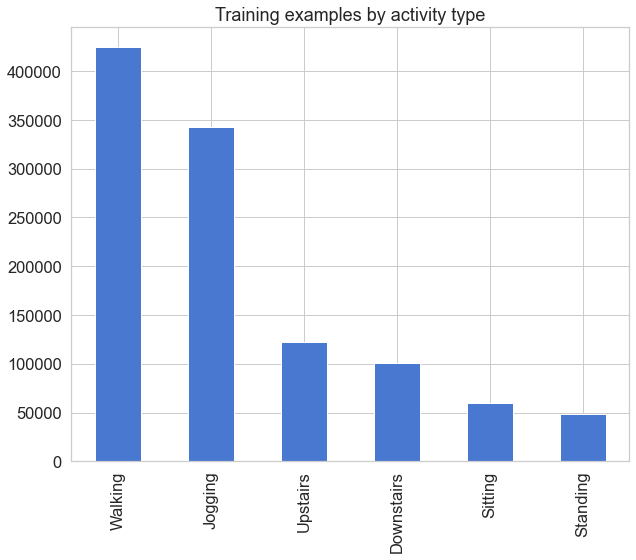

In [5]:
# Comparing the number of datas for each of class in a bar-graph
data['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

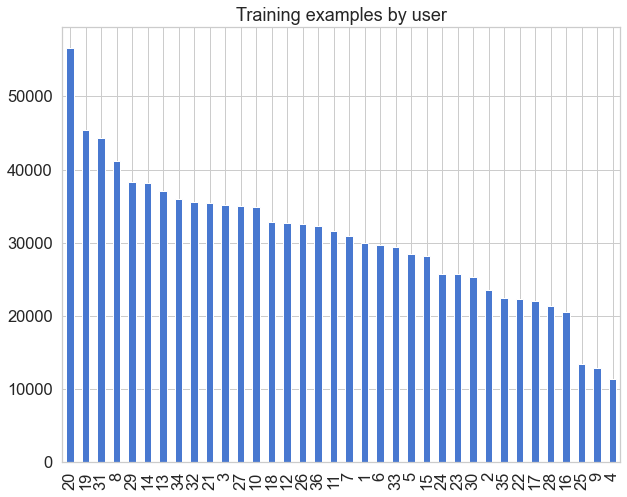

In [6]:
# Displayng number of datas shared by 30 different users in a bar-graph
data['user'].value_counts().plot(kind='bar', title='Training examples by user');

In [7]:
# Plotting the graph for each of activities in 200 timesteps
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 10), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [8]:
activities = data['activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

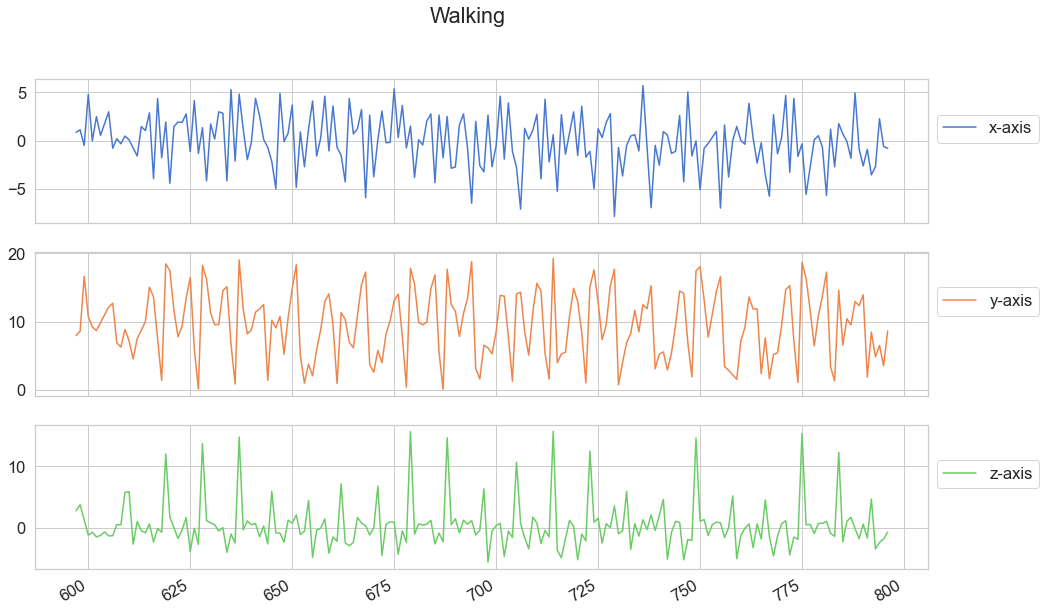

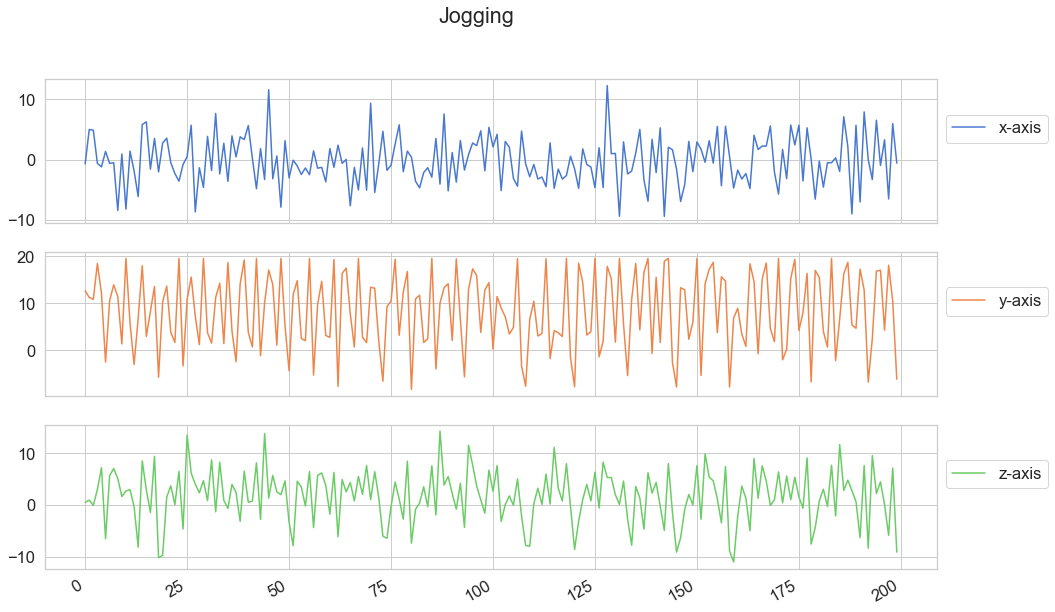

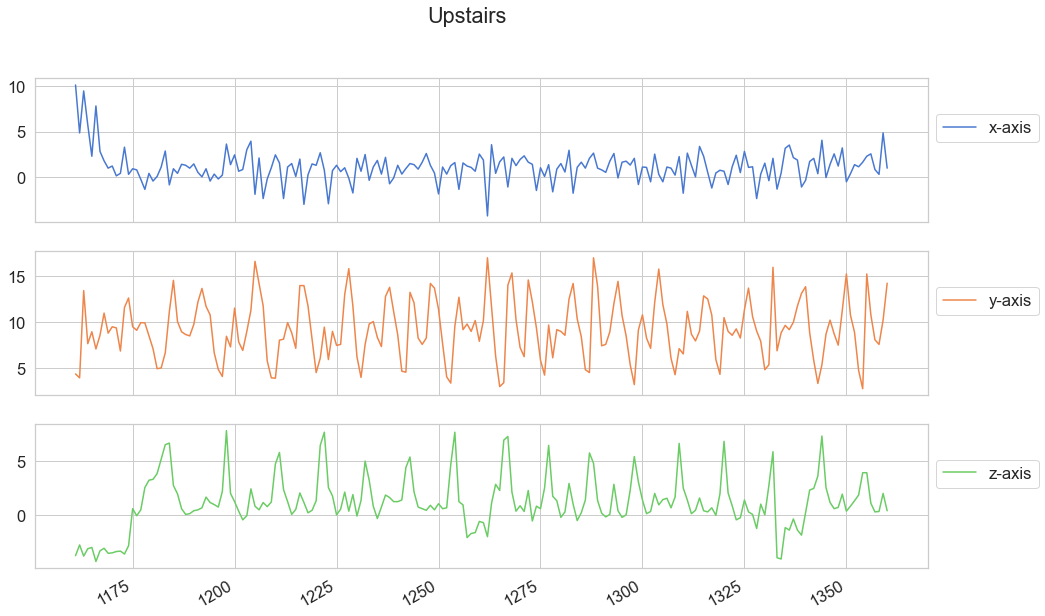

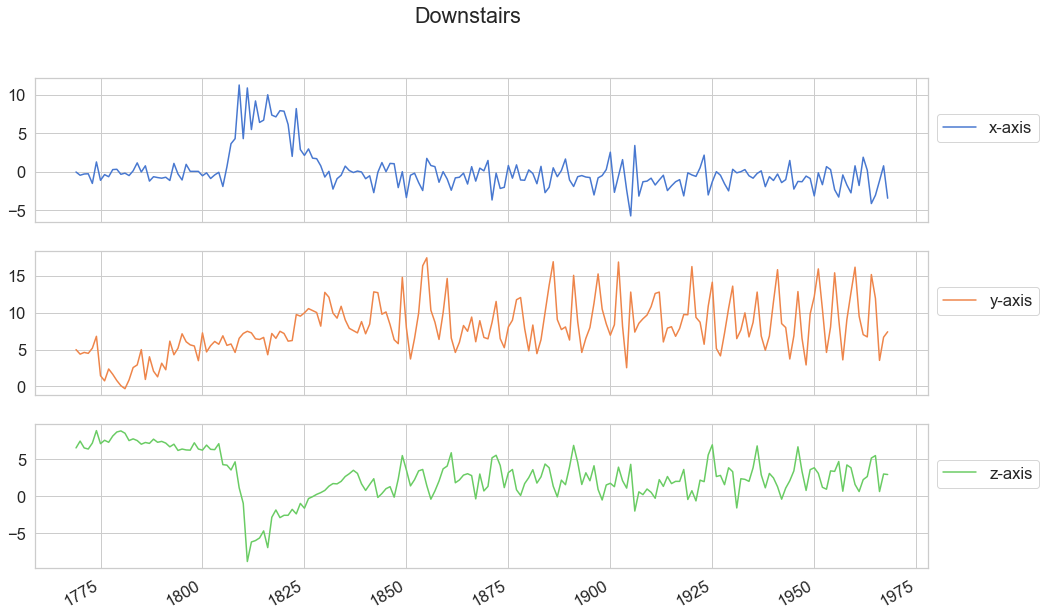

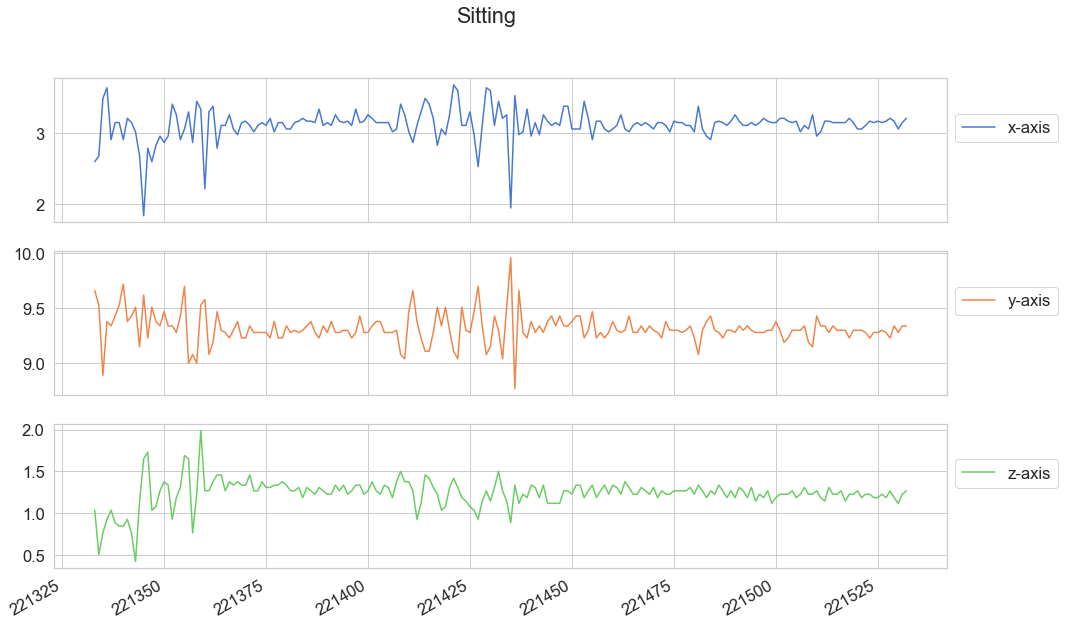

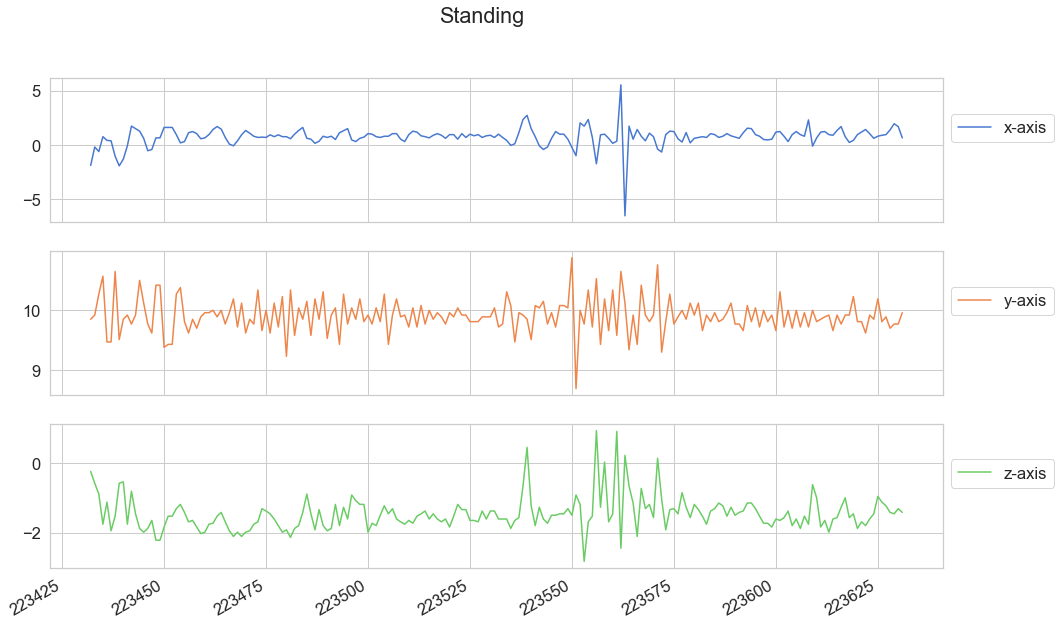

In [9]:
for activity in activities:
    plot_activity(activity,data)

# DATA PREPROCESSING: Balancing, Standardizing and Frame Preparation


BALANCING DATA

In [10]:
df = data.drop(['user', 'timestamp'], axis = 1).copy()
df.head()

,activity,x-axis,y-axis,z-axis
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [11]:
df.tail()

,activity,x-axis,y-axis,z-axis
1098199,Sitting,9.00,-1.57,1.69
1098200,Sitting,9.04,-1.46,1.73
1098201,Sitting,9.08,-1.38,1.69
1098202,Sitting,9.00,-1.46,1.73
1098203,Sitting,8.88,-1.33,1.61


In [12]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [13]:
Walking = df[df['activity']=='Walking'].head(48395).copy()
Jogging = df[df['activity']=='Jogging'].head(48395).copy()
Upstairs = df[df['activity']=='Upstairs'].head(48395).copy()
Downstairs = df[df['activity']=='Downstairs'].head(48395).copy()
Sitting = df[df['activity']=='Sitting'].head(48395).copy()
Standing = df[df['activity']=='Standing'].copy()


In [14]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(290370, 4)

In [15]:
balanced_data['activity'].value_counts()

Upstairs      48395
Sitting       48395
Downstairs    48395
Jogging       48395
Standing      48395
Walking       48395
Name: activity, dtype: int64

In [16]:
balanced_data.tail()

,activity,x-axis,y-axis,z-axis
1095665,Standing,-4.99,8.39,-0.38
1095666,Standing,-5.13,8.24,-0.42
1095667,Standing,-4.56,8.50,-0.89
1095668,Standing,-4.48,8.54,-1.08
1095669,Standing,-4.94,8.28,-0.84


STANDARDIZING DATA

In [17]:
X = balanced_data[['x-axis', 'y-axis', 'z-axis']]
y = balanced_data['activity']

In [18]:
X.shape

(290370, 3)

In [19]:
y.shape

(290370,)

In [20]:
# Standardizing the values of features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x-axis', 'y-axis', 'z-axis'])
scaled_X['activity'] = y.values

scaled_X

,x-axis,y-axis,z-axis,activity
0,-0.034489,0.076967,0.266487,Walking
1,0.017285,0.187547,0.495750,Walking
2,-0.290769,1.637371,-0.075839,Walking
3,0.716230,0.573348,-0.650569,Walking
4,-0.202754,0.298127,-0.537507,Walking
...,...,...,...,...
290365,-1.143388,0.145748,-0.464958,Standing
290366,-1.169996,0.118686,-0.474181,Standing
290367,-1.061662,0.165594,-0.582554,Standing
290368,-1.046457,0.172811,-0.626365,Standing


FRAME PREPARATION

In [21]:
# Frame preparation of the data
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(scaled_X) - N_TIME_STEPS, step):
    xs = scaled_X['x-axis'].values[i: i + N_TIME_STEPS]
    ys = scaled_X['y-axis'].values[i: i + N_TIME_STEPS]
    zs = scaled_X['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(scaled_X['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [22]:
np.array(segments).shape

(14509, 3, 200)

In [23]:
labels

['Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Walking',
 'Wa

In [24]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

In [25]:
# Converting the label into a one-hot encoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[5 5 5 ... 3 3 3]
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [26]:
label_encoder.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype='<U10')

In [27]:
reshaped_segments.shape

(14509, 200, 3)

Let's split the data into training and test (20%) set:

In [28]:
# Splitting the training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, onehot_encoded, test_size=0.2)

In [29]:
len(X_train)

11607

In [30]:
len(X_test)

2902

In [31]:
X_train.shape

(11607, 200, 3)

In [32]:
X_train[0],y_train[0]

(array([[ 1.6695025 ,  2.1503546 ,  2.0344179 ],
        [ 1.1297317 ,  0.8180329 ,  1.1069244 ],
        [ 0.96247864, -0.29001775, -0.565605  ],
        [-0.2310991 ,  3.488378  ,  3.488378  ],
        [ 0.7211023 ,  0.7211023 ,  0.7211023 ],
        [-0.19498767,  1.4433309 ,  1.4433309 ],
        [ 1.0061924 ,  0.7572137 ,  0.7211023 ],
        [ 1.3844122 ,  2.1636589 ,  1.8443577 ],
        [ 1.7493277 ,  1.070813  ,  0.6279728 ],
        [ 1.2627738 ,  0.8617468 , -0.39265025],
        [-0.6017164 ,  0.06729534,  2.2662914 ],
        [ 3.307821  ,  3.307821  , -0.19498767],
        [ 0.8617468 ,  0.8617468 , -0.19498767],
        [ 1.070813  ,  1.070813  ,  0.54814756],
        [ 1.0784154 ,  1.5687705 ,  2.186466  ],
        [ 1.8139482 ,  1.6847073 ,  1.1069244 ],
        [ 0.71540046,  1.1012226 ,  0.612768  ],
        [-0.4857797 , -0.8221862 ,  0.35048497],
        [ 2.8858874 ,  2.8535771 ,  0.15472302],
        [ 1.1582407 , -0.31092438,  0.71540046],
        [ 0.71540046

## BUILDING THE CNN-LSTM MODEL

In [33]:
#Importing Required Libraries for the model
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Conv1D, MaxPooling1D, LSTM

In [34]:
# Creating model
model = Sequential([Conv1D(filters=128, kernel_size=3, activation='relu',padding = 'same',input_shape=(200,3), name = 'cnn_1'),
    MaxPooling1D(pool_size=2, name = 'maxpooling_1'),
    Conv1D(filters=128, kernel_size=3, activation='relu',padding = 'same', name = 'cnn_2'),
    BatchNormalization(name='batchnorm_layer'),
    MaxPooling1D(pool_size=2, name = 'maxpooling_2'),
         
    LSTM(64, return_sequences = True, name = 'lstm_1'),
    Dropout(0.3, name = 'Dropout_1'),
    LSTM(32, return_sequences = False, name = 'lstm_2'),
    Dropout(0.3, name = 'Dropout_2'),

    Dense(32, activation= 'relu', name = 'dense_1'),
    Dropout(0.3, name = 'Dropout_3'),
    Dense(6, activation = 'softmax', name = 'output')])


In [35]:
# Compiling the model
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_1 (Conv1D)               (None, 200, 128)          1280      
_________________________________________________________________
maxpooling_1 (MaxPooling1D)  (None, 100, 128)          0         
_________________________________________________________________
cnn_2 (Conv1D)               (None, 100, 128)          49280     
_________________________________________________________________
batchnorm_layer (BatchNormal (None, 100, 128)          512       
_________________________________________________________________
maxpooling_2 (MaxPooling1D)  (None, 50, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 64)            49408     
_________________________________________________________________
Dropout_1 (Dropout)          (None, 50, 64)            0

## TRAINING THE MODEL

In [36]:
# prepare callbacks
from keras.callbacks import ModelCheckpoint

callbacks= [ModelCheckpoint('my_model_balanced.h5', save_weights_only=False, save_best_only=True, verbose=1)]

In [37]:
# training the model
from timeit import default_timer as timer
start = timer()

history = model.fit(X_train, y_train, epochs = 15, validation_data = (X_test,y_test), verbose=1, callbacks = [callbacks])

end = timer()
print("\n")
print("Time: ",(end - start),"secs = ",(end - start)/3600,"hours")


Epoch 1/15
363/363 [==============================] - 42s 98ms/step - loss: 0.7982 - accuracy: 0.7248 - val_loss: 0.3707 - val_accuracy: 0.8594

Epoch 00001: val_loss improved from inf to 0.37067, saving model to my_model_balanced.h5
Epoch 2/15
363/363 [==============================] - 33s 90ms/step - loss: 0.2007 - accuracy: 0.9441 - val_loss: 0.1341 - val_accuracy: 0.9673

Epoch 00002: val_loss improved from 0.37067 to 0.13406, saving model to my_model_balanced.h5
Epoch 3/15
363/363 [==============================] - 33s 91ms/step - loss: 0.1748 - accuracy: 0.9523 - val_loss: 0.1302 - val_accuracy: 0.9628

Epoch 00003: val_loss improved from 0.13406 to 0.13023, saving model to my_model_balanced.h5
Epoch 4/15
363/363 [==============================] - 33s 92ms/step - loss: 0.1034 - accuracy: 0.9706 - val_loss: 0.0587 - val_accuracy: 0.9800

Epoch 00004: val_loss improved from 0.13023 to 0.05871, saving model to my_model_balanced.h5
Epoch 5/15
363/363 [==============================] 

## EVALUATION AND THE PERFORMANCE METRICS

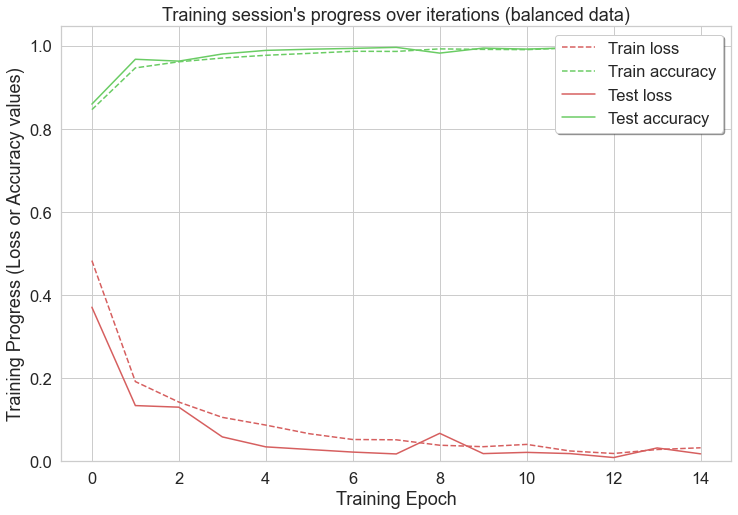

In [47]:
# Plotting loss and accuracy graph
plt.figure(figsize=(12, 8))

plt.plot(np.array(history.history['loss']), "r--", label="Train loss")
plt.plot(np.array(history.history['accuracy']), "g--", label="Train accuracy")

plt.plot(np.array(history.history['val_loss']), "r-", label="Test loss")
plt.plot(np.array(history.history['val_accuracy']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations (balanced data)")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

In [39]:
# Evaluating model
model.evaluate(X_test, y_test)

91/91 [==============================] - 3s 27ms/step - loss: 0.0179 - accuracy: 0.9952


[0.017907045781612396, 0.9951757192611694]

In [40]:
# Prediction of testing data
test_pred = np.argmax(model.predict(X_test), axis=1)

In [41]:
test_pred.shape

(2902,)

In [42]:
test_pred[100]

3

CONFUSION MATRIX

In [43]:
# Confusion Matrix for this classificatin
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

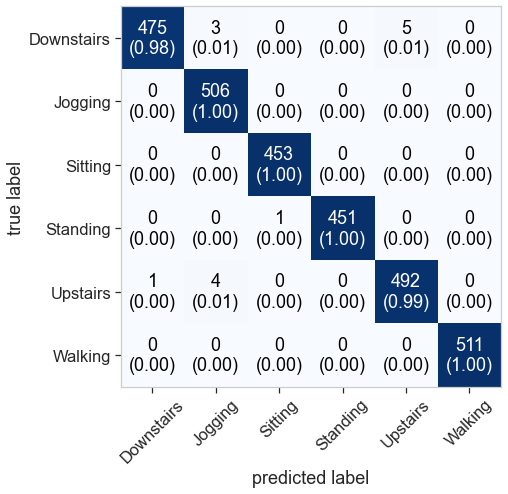

In [44]:
max_test = np.argmax(y_test, axis=1)
mat = confusion_matrix(max_test, test_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label_encoder.classes_, show_normed=True, figsize=(7,7))

In [45]:
# Displaying classification report
from sklearn.metrics import classification_report
print(classification_report(label_encoder.classes_[max_test], label_encoder.classes_[test_pred]))

              precision    recall  f1-score   support

  Downstairs       1.00      0.98      0.99       483
     Jogging       0.99      1.00      0.99       506
     Sitting       1.00      1.00      1.00       453
    Standing       1.00      1.00      1.00       452
    Upstairs       0.99      0.99      0.99       497
     Walking       1.00      1.00      1.00       511

    accuracy                           1.00      2902
   macro avg       1.00      1.00      1.00      2902
weighted avg       1.00      1.00      1.00      2902

